In [1]:
import numpy as np
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os 
import sys
import imageio
import xml.etree.ElementTree as ET
from xml.dom import minidom

# Config

In [10]:
main_dir = '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly'
#config_file = 'configs/Step_3_MIMIC_Object_Detector_256_Costophrenic_Recess.yaml'
config_file = 'configs/Step_3_MIMIC_Object_Detector_256_Pacemaker.yaml'

config_path = os.path.join(main_dir, config_file)
config = yaml.load(open(config_path))

In [11]:
config

{'BATCHSIZE': 2,
 'CLASSES': ['pacemaker'],
 'CROP': False,
 'EPSILON': '1e-10',
 'IMG_H': 256,
 'IMG_PATH': '/ocean/projects/asc170022p/singla/CSV_MIMIC/ObjectDetector_PA/pacemaker/img/',
 'IMG_W': 256,
 'LEARNING_RATE': 0.001,
 'MINIBATCH': 64,
 'MOMENTUM': 0.9,
 'NMS_THRESHOLD': 0.7,
 'NUMS_PROPOSAL': 2000,
 'POOLED_H': 7,
 'POOLED_W': 7,
 'SUFFIX': '.jpg',
 'WEIGHT_DECAY': 0.0005,
 'XML_PATH': '/ocean/projects/asc170022p/singla/CSV_MIMIC/ObjectDetector_PA/pacemaker/xml/',
 'ckpt_dir_continue': 'output/ObjectDetector/pacemaker',
 'image_dir': '',
 'log_dir': 'output/ObjectDetector',
 'name': 'pacemaker',
 'num_channel': 1,
 'starting_step': 1,
 'vgg_checkpoint': 'output/classifier/StanfordCheXpert_256_VGG/cp_epoch0.ckpt'}

# View Train Dataset

In [12]:
def read_data(xml_path, img_path, CLASSES, one_hot=True):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = root.findall("object")
    names = []
    gtbboxes = np.zeros([len(objects), 4], dtype=np.int32)
    for idx, obj in enumerate(objects):
        curr_name = obj.find("name").text
        if curr_name not in CLASSES:
            continue
        names.append(curr_name)
        xmin = int(obj.find("bndbox").find("xmin").text)
        xmax = int(obj.find("bndbox").find("xmax").text)
        ymin = int(obj.find("bndbox").find("ymin").text)
        ymax = int(obj.find("bndbox").find("ymax").text)
        gtbboxes[idx, 0] = (xmin + xmax)//2
        gtbboxes[idx, 1] = (ymin + ymax)//2
        gtbboxes[idx, 2] = xmax - xmin
        gtbboxes[idx, 3] = ymax - ymin
    #img = np.array(Image.open(img_path)) #
    img = np.array(imageio.imread(img_path))
    if one_hot:
        labels = np.zeros([len(objects), len(CLASSES)])
        for idx, name in enumerate(names):
            labels[idx, CLASSES.index(name)] = 1
    else:
        labels = np.zeros([len(objects)])
        for idx, name in enumerate(names):
            labels[idx] = CLASSES.index(name)
    return img, gtbboxes, labels

In [13]:
img_path = config['IMG_PATH']
xml_path = config['XML_PATH']
number_of_samples_to_plot = 10

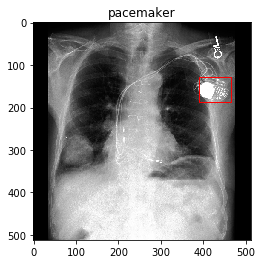

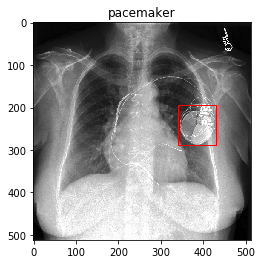

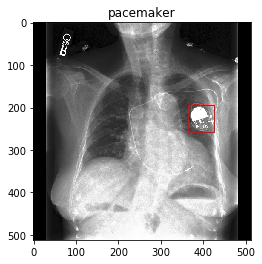

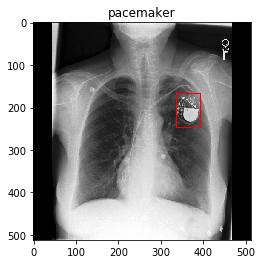

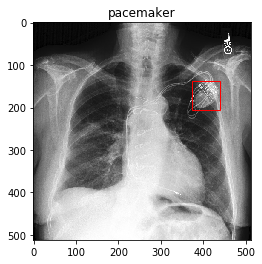

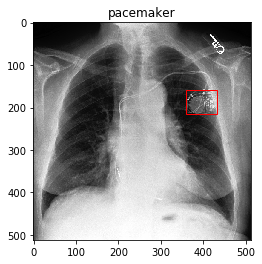

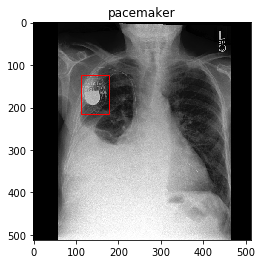

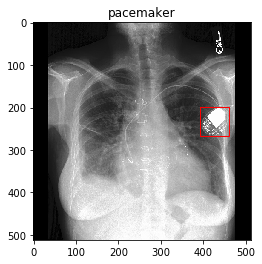

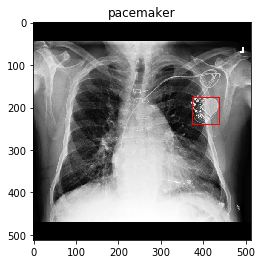

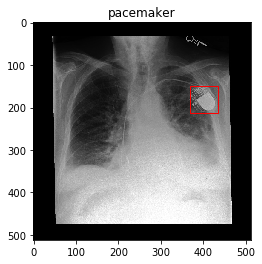

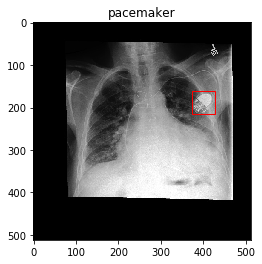

In [14]:
all_xmls = os.listdir(xml_path)
counter = 0
for xml in all_xmls:
    file_name= xml.split('.')[0]
    img_file_path = os.path.join(img_path, file_name + config['SUFFIX']) 
    if os.path.exists(img_file_path):
        im, bboxes_1, labels = read_data(os.path.join(xml_path, xml), img_file_path, 
                                          config['CLASSES'], one_hot=True)
        fig,ax = plt.subplots(1)
        ax.imshow(im,cmap='gray')
        for i in range(bboxes_1.shape[0]):
            bboxes = bboxes_1[i]
            X0 = np.int32(bboxes[ 0] - bboxes[ 2]/2)
            X1 = np.int32(bboxes[0] + bboxes[ 2]/2)
            Y0 = np.int32(bboxes[1] - bboxes[ 3]/2)
            Y1 = np.int32(bboxes[ 1] + bboxes[ 3]/2)
            X, Y, W, H = X0 , Y0, X1 - X0, Y1 - Y0
            if labels[i,0] == 1:
                ax.set_title(config['CLASSES'][0])
                rect1 = patches.Rectangle((X,Y),W,H,linewidth=1,edgecolor='r',facecolor='none')
            else:
                ax.set_title(config['CLASSES'][1])
                rect1 = patches.Rectangle((X,Y),W,H,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect1)
        plt.show()
        counter += 1
        if counter > number_of_samples_to_plot:
            break